### ResNet

- Residual Learning의 수학적 원리부터 실제 구현까지 다루는 과정입니다. 단순히 코드를 따라 치는 것이 아니라, 최적화 이론과 신경망 역학의 관점에서 ResNet이 왜 작동하는지 깊이 이해하는 것을 목표로 합니다.

- 저자 `이재욱`


### 1. Gradient Backpropagation via Identity Mapping
- ResNet의 핵심은 Gradient Vanishing(기울기 소실) 문제를 구조적을 해결한 것이라고 생각한다

Residual Block의 수식은 다음과 같이 정의할수 있다
$$ x_{l+1} = x_l + \mathcal{F}(x_l, \mathcal{W}_l) $$

이를 재귀적으로 전개하면, 임의의 깊은 층 $L$과 얕은 층 $l$ 사이의 관계는 다음과 같습니다:
$$ x_L = x_l + \sum_{i=l}^{L-1} \mathcal{F}(x_i, \mathcal{W}_i) $$

손실 함수 $\mathcal{L}$에 대한 $x_l$의 기울기를 Chain Rule로 유도하면 다음과 같습니다:
$$ \frac{\partial \mathcal{L}}{\partial x_l} = \frac{\partial \mathcal{L}}{\partial x_L} \frac{\partial x_L}{\partial x_l} = \frac{\partial \mathcal{L}}{\partial x_L} \left( 1 + \frac{\partial}{\partial x_l} \sum_{i=l}^{L-1} \mathcal{F}(x_i, \mathcal{W}_i) \right) $$


여기서 **$1$** 항은 기울기가 감쇠(Decay) 없이 상위 층에서 하위 층으로 직접 전달됨을 보장합니다. 이는 깊이에 상관없이 학습 신호가 보존됨을 수학적으로 증명합니다

이것을 감각적으로 정의하면 다음과 같이 설명할수있습니다.
일반 deep net

→ “기울기 = (작은 수) × (작은 수) × (작은 수) × … → 0으로 증발”

ResNet

→ “기울기 = (1 + 작은 것) × (1 + 작은 것) × … + (직통 1 경로들 합)”

기본적으로 1 근처에서 왔다 갔다하면서,그 위에 작은 조정(residual)들을 얹는 구조 


### 2. Optimization Landscape Smoothing (최적화 지형 평활화)

AI를 공부하다보면 당연스럽게 봤겠지만 
Skip Connection은 Loss Surface의 **Curvature(곡률)**을 완화시킵니다. *Li et al. (2018)*의 시각화 연구에 따르면, ResNet은 Non-convexity가 심한 일반적인 Deep Network와 달리, Convex에 가까운 매끄러운 지형을 형성하여 **Stochastic Gradient Descent (SGD)**가 Global Minima로 수렴하는 것을 용이하게 합니다.

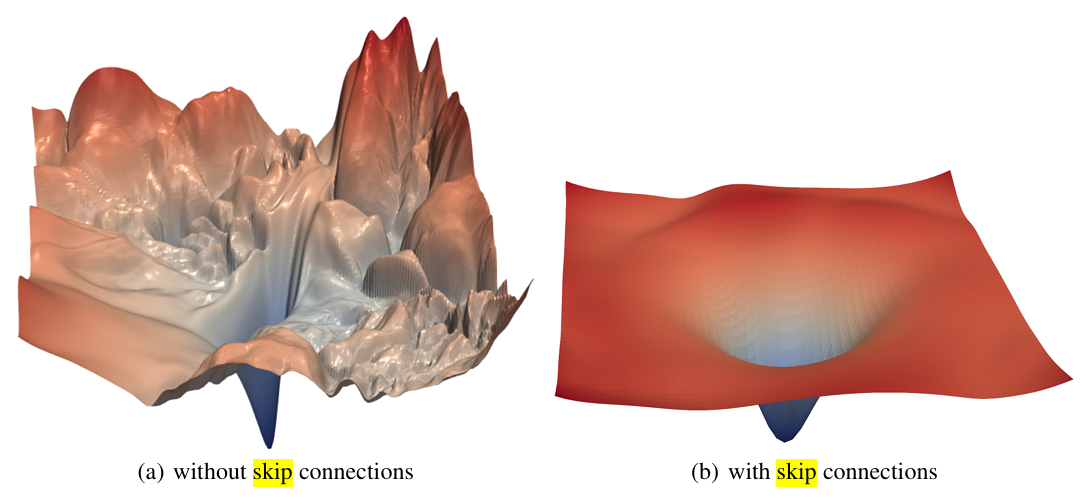

### 3. Unraveled View of ResNets (ResNet의 풀어진 관점)
ResNet은 $L$개의 Residual Block이 있을 때, $2^L$개의 서로 다른 경로(Path)를 갖는 **Ensemble of Shallow Networks**로 해석될 수 있습니다. 이는 특정 경로의 가중치가 손상되더라도 전체 성능이 급격히 저하되지 않는(Robustness) 이유를 설명합니다.


## Conv 1x1의 의미를 이해하고 넘어가자!!

**Definition**: $1 \times 1$ Convolution은 공간적 차원(Spatial Dimensions, $H \times W$)을 유지한 채, 채널 차원(Channel Dimension, $C$)에 대해서만 수행되는 **Linear Projection**입니다.

**Purpose**:
1.  **Dimensionality Reduction (Bottleneck)**: 연산 복잡도 $\mathcal{O}(H \cdot W \cdot C_{in} \cdot C_{out})$를 제어하기 위해 채널 수를 축소합니다.
2.  **Feature Interaction**: 채널 간의 정보(Information)를 선형 결합(Linear Combination)하여 새로운 특징을 추출합니다.

`conv3x3`과 `conv1x1`을 구현하고 이해보겠습니다.

```python
nn.Conv2d(
    in_channels,  # 입력 채널 수 (예: RGB 이미지는 3)
    out_channels, # 출력 채널 수 (필터의 개수)
    kernel_size,  # 필터의 크기 (예: 3은 3x3 필터)
    stride=1,     # 필터가 이동하는 간격 (2면 이미지가 절반으로 줄어듦)
    padding=0,    # 이미지 테두리에 0을 채워 넣는 두께 (크기 보존용)
    bias=True     # 편향(Bias) 사용 여부 (BatchNorm 앞에서는 보통 False)
)
```


In [10]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

def conv1x1(in_planes,out_planes,stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)



**Memory Optimization**: 이제 `ReLU(inplace=True)`를 사용하여 추가적인 메모리 할당 없이 Activation을 수행하겠습니다

In [11]:
class BasicBlock(nn.Module):
    '''
    BasicBlock의 Docstring
    '''
    expansion = 1 # ResNet의 깊이를 경정하는 파라미터
    
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        '''
        inplanes: 블록으로 들어오는 입력 데이터의 채널 수입니다.
        planes: 블록이 내보낼 출력 데이터의 채널 수 (필터의 개수)입니다.
        stride: 이미지 크기를 줄일지 말지 결정합니다. (1이면 유지, 2면 가로세로 반으로 축소)
        downsample: 스킵 연결(Skip Connection)을 위해 입력 $x$의 크기나 채널을 조절해주는 별도의 레이어입니다.
        '''
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        
        
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        
        # Identity Mapping 
        # ResNet의 깊이가 깊어질수록 신호가 0으로 수렴하는 것을 막기 위해 x를 더하게되는데
        # conv1 에서 stride=2를 쓴다면 이미지가 작아지거나 채널수가 바뀌면 out 과 x의 모양이 달라져서 더하기 할수x
        # 그래서 downsample을 사용하여 x를 변환시켜서 더하기 할수있게 함
        # 현재는 stride를 안써서 딱히 안써도 됨ㅋㅋㅋ
        
        if self.downsample is not None:
            identity = self.downsample(x)
            
        # Element-wise Addition (Residual Connection)
        
        out += identity
        out = self.relu(out)
        
        
        return out      
        

    

ResNet Architecture (Modular Design)

In [12]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # maxpool로 최댓값만 남겨서 특징을 추출!!!
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        # Weight Initialization (He Init)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


### 1. Optimization Objective (Loss Function)
**Cross-Entropy Loss**는 실제 분포 $P$와 예측 분포 $Q$ 사이의 **Kullback-Leibler Divergence (KL-Divergence)**를 최소화하는 것과 동등합니다.
$$ \mathcal{L}_{CE} = -\sum_{c=1}^{M} y_{o,c} \log(p_{o,c}) $$
분류 문제에서 MSE 대신 Cross-Entropy를 사용하는 이유는 **Maximum Likelihood Estimation (MLE)** 관점에서 적합하기 때문이며, Softmax와 결합 시 Backpropagation 과정에서 Gradient가 포화(Saturate)되지 않고 안정적으로 전달되기 때문입니다.

### 2. Performance Metrics (성능 지표)
**Accuracy Paradox**: Class Imbalance 상황에서 Accuracy는 모델의 성능을 왜곡합니다.
- **Precision (정밀도)**: $ \frac{TP}{TP + FP} $ (모델이 True라고 한 것 중 실제 True의 비율)
- **Recall (재현율)**: $ \frac{TP}{TP + FN} $ (실제 True 중 모델이 찾은 비율)
- **F1-Score**: Precision과 Recall의 **Harmonic Mean (조화 평균)**. $ 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} $


In [13]:
import torch.optim as optim

def train_step(model, inputs, labels, criterion, optimizer):
    """Performs a single optimization step."""
    model.train()
    
    # 1. Gradient Initialization
    optimizer.zero_grad()
    
    # 2. Forward Propagation
    outputs = model(inputs)
    
    # 3. Loss Computation
    loss = criterion(outputs, labels)
    
    # 4. Backward Propagation (Gradient Calculation)
    loss.backward()
    
    # 5. Parameter Update
    optimizer.step()
    
    return loss.item()

def calculate_metrics(outputs, labels):
    """Calculates Accuracy."""
    _, preds = torch.max(outputs, 1)
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

# Test Configuration
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Dummy Data
inputs = torch.randn(4, 3, 224, 224)
labels = torch.tensor([1, 0, 9, 5])

# Execution
loss = train_step(model, inputs, labels, criterion, optimizer)
print(f"Loss: {loss:.4f}")

Loss: 2.4247
